In [7]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from collections import Counter

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from concurrent.futures import ProcessPoolExecutor

import random

In [8]:
TARGET_SIZE = (64, 64)

In [9]:
def parse_filename(filename):
    components = filename.split("_")
    offset = 0
    
    if "-" in components[1]:
        offset = 1
    
    if len(components) < 6 + offset:
        return False, []
   
    x = int(components[1 + offset])
    y = int(components[2 + offset])
    z = int(components[3 + offset])
    r = int(components[4 + offset])
    is_flying = int(components[5 + offset].split(".")[0])

    if x == 0 and y == 0 and z == 0 and r == 0:
        return False, []

    return True, [x, y, z, r, is_flying]

In [10]:
image_data = []
label_data = []

for date_folder in os.listdir("data"):
    date_folder_path = os.path.join("data", date_folder)

    if os.path.isdir(date_folder_path):
        for filename in os.listdir(date_folder_path):
            if filename.endswith(".png"):
                image_path = os.path.join(date_folder_path, filename)
                valid, components = parse_filename(filename)
                
                if valid:
                    image_data.append(image_path)
                    label_data.append(components)

In [11]:
count = Counter([tuple(x) for x in label_data])
count = count.most_common()

count = [x for x in count if x[1] >= 700]

f_image_data = [image_data[i] for i in range(len(label_data)) if tuple(label_data[i]) in [x[0] for x in count]]
f_label_data = [label_data[i] for i in range(len(label_data)) if tuple(label_data[i]) in [x[0] for x in count]]

f_label_data = ["_".join([str(x) for x in y]) for y in f_label_data]

tokenizer = {x: i for i, x in enumerate(set(f_label_data))}
detokenizer = {i: x for i, x in enumerate(set(f_label_data))}

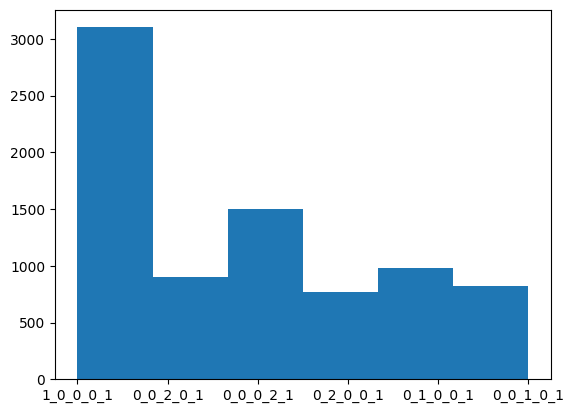

In [12]:
# make a histogram plot of the data
plt.hist(f_label_data, bins=len(tokenizer))
plt.show()


In [13]:
def preprocess_image(image_path):
    image = load_img(image_path, target_size=TARGET_SIZE) 
    image = img_to_array(image) / 255.0

    return image

In [14]:
def preprocess_and_cache_images(image_paths, cache_folder, max_workers):
    os.makedirs(cache_folder, exist_ok=True)
    cached_images = []

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        for image_path in image_paths:
            cached_path = os.path.join(cache_folder, os.path.basename(image_path) + ".npy")
            if os.path.exists(cached_path):
                cached_images.append(np.load(cached_path))
            else:
                image = preprocess_image(image_path)
                np.save(cached_path, image)
                cached_images.append(cached_path)

    return cached_images

In [15]:
f_image_data = preprocess_and_cache_images(f_image_data, "cache", max_workers=os.cpu_count())
one_hot_labels = tf.keras.utils.to_categorical([tokenizer[x] for x in f_label_data])

In [16]:
print(len(label_data), len(image_data), len(f_label_data), len(f_image_data))

11849 11849 8082 8082


In [17]:
image_train, image_val, label_train, label_val = train_test_split(
    f_image_data, one_hot_labels, test_size=0.2, random_state=42)

image_train = np.array(image_train)
image_val = np.array(image_val)
label_train = np.array(label_train)
label_val = np.array(label_val)

print(image_train.shape, image_val.shape, label_train.shape, label_val.shape)

(6465, 64, 64, 3) (1617, 64, 64, 3) (6465, 6) (1617, 6)


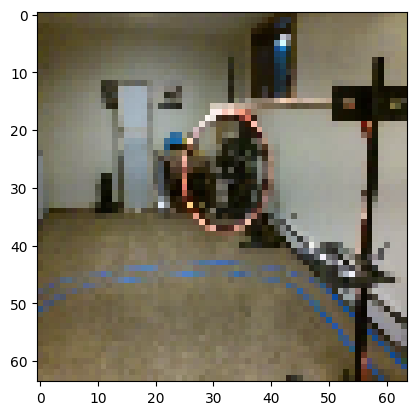

0_2_0_0_1


In [18]:
# display a random picture from the dataset + label
random_index = random.randint(0, len(image_train))
plt.imshow(image_train[random_index])
plt.show()
print(detokenizer[np.argmax(label_train[random_index])])

In [63]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(len(tokenizer), activation='softmax'))

# model.add(layers.Conv2D(128, (3, 3), , activation="relu", padding="same"))
# model.add(layers.MaxPooling2D(pool_size=(3, 3)))
# model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
# model.add(layers.MaxPooling2D(pool_size=(3, 3)))
# model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# model.add(layers.Flatten())

# model.add(layers.Dense(64, activation="relu"))
# model.add(layers.Dense(len(tokenizer), activation="softmax")) 

In [64]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [21]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        image_paths_temp = [self.image_paths[k] for k in indexes]
        labels_temp = [self.labels[k] for k in indexes]

        images = []
        for image_path in image_paths_temp:
            if isinstance(image_path, str):
                images.append(np.load(image_path))
            else:
                images.append(image_path)

        return np.array(images), np.array(labels_temp)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [73]:
train_generator = DataGenerator(image_train, label_train, batch_size=128)
val_generator = DataGenerator(image_val, label_val, batch_size=128)

model.fit(
    train_generator,
    epochs=8,
    validation_data=val_generator
)

Epoch 1/8
50/50 [==============================] - 1s 27ms/step - loss: 0.2038 - accuracy: 0.9162 - val_loss: 0.9334 - val_accuracy: 0.8535
Epoch 2/8
50/50 [==============================] - 1s 24ms/step - loss: 0.2130 - accuracy: 0.9134 - val_loss: 0.9537 - val_accuracy: 0.8509
Epoch 3/8
50/50 [==============================] - 1s 24ms/step - loss: 0.1960 - accuracy: 0.9230 - val_loss: 0.9260 - val_accuracy: 0.8503
Epoch 4/8
50/50 [==============================] - 1s 24ms/step - loss: 0.1974 - accuracy: 0.9239 - val_loss: 0.9231 - val_accuracy: 0.8522
Epoch 5/8
50/50 [==============================] - 1s 24ms/step - loss: 0.1943 - accuracy: 0.9203 - val_loss: 0.8966 - val_accuracy: 0.8529
Epoch 6/8
50/50 [==============================] - 1s 24ms/step - loss: 0.2007 - accuracy: 0.9169 - val_loss: 1.0299 - val_accuracy: 0.8438
Epoch 7/8
50/50 [==============================] - 1s 24ms/step - loss: 0.1932 - accuracy: 0.9216 - val_loss: 0.9831 - val_accuracy: 0.8405
Epoch 8/8
50/50 [===

In [71]:
directory = "models/COPILOTVA85_11-1-23"
os.makedirs(directory, exist_ok=False)

model.save(f"{directory}/model.h5")
np.save(f"{directory}/tokenizer.npy", tokenizer)
np.save(f"{directory}/detokenizer.npy", detokenizer)

In [ ]:
# def predict(filename, from_folder=False):
#     image = None

#     if from_folder:
#         image = preprocess_image(filename)

#     image = np.expand_dims(image or filename, axis=0)

#     if not from_folder:
#         plt.imshow(image[0])

#     predictions = model.predict(image)[0]
#     predictions = np.argmax(predictions)

#     result = detokenizer[predictions]

#     return result


In [ ]:
# ran_index = random.randint(0, len(image_val))
# predictions = predict(image_val[ran_index], from_folder=False)
# label = label_val[ran_index]

# print(f"predictions | {predictions}")
# print(f"label       | {detokenizer[np.argmax(label)]}")
